In [2]:
import sys
import sys
!{sys.executable} -m pip install google-generativeai

sys.path.append("..")
import os
import json
import seaborn as sns
from collections import Counter
import openai
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir
from games.ultimatum.ultimatum_multi_turn.game import MultiTurnUltimatumGame
import itertools
from collections import defaultdict
import os
import json
import openai
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir
import matplotlib.pyplot as plt
import warnings
import pandas as pd
from pandas.errors import SettingWithCopyWarning
import seaborn as sns
import matplotlib.pyplot as plt
colormap = sns.color_palette("Blues") 
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))


Defaulting to user installation because normal site-packages is not writeable
  Using cached google_generativeai-0.4.1-py3-none-any.whl (137 kB)
  Using cached google_ai_generativelanguage-0.4.0-py3-none-any.whl (598 kB)
  Using cached proto_plus-1.23.0-py3-none-any.whl (48 kB)
  Using cached grpcio_status-1.62.1-py3-none-any.whl (14 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 4.9 MB/s eta 0:00:004.0 MB/s eta 0:00:01
  Using cached grpcio-1.62.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.5 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.59.0
    Uninstalling grpcio-1.59.0:
      Successfully uninstalled grpcio-1.59.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the f

2024-03-24 08:03:32.087 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [3]:
AGENTS = ["gpt-4-1106-preview", "claude-2.1", "claude-2", "gpt-3.5-turbo-1106",]
AGENTS_CLEAN_NAMES = ["GPT-4", "Claude-2.1", "Claude-2", "GPT-3.5"]
rename_dict = {k:v for k,v in zip(AGENTS, AGENTS_CLEAN_NAMES)}



In [4]:
%env OPENAI_API_KEY="g"

env: OPENAI_API_KEY="g"


In [5]:
#game_states[0].game_state

#### Utils Code

In [6]:
def get_from_summary(key, game_state, default=None):
    if key in game_state.game_state[-1]['summary']:
        return game_state.game_state[-1]['summary'][key]
    else:
        return default

def replace_names(df):
    df_copy = df.copy()
    df_copy["model_1"] = df_copy["model_1"].replace(rename_dict)
    df_copy["model_2"] = df_copy["model_2"].replace(rename_dict)
    return df_copy
    
def get_player_valuation(game_state, default=None):
    if "player_valuation" in game_state.game_state[0]["settings"]:
        vals = game_state.game_state[0]["settings"]["player_valuation"]
        return vals
    else:
        return default
        
def compute_game_summary(game_states):

    game_name = np.array([g.__class__.__name__ for g in game_states])[:, None]
    models = np.array([[ p.model for p in g.players] for g in game_states])
    outcomes = np.array([get_from_summary('player_outcome', g) for g in game_states])
    valuations = np.array([get_player_valuation(g, default=[None,None])  for g in game_states])
    initial_resources = np.array([get_from_summary('initial_resources', g) for g in game_states])
    final_resources = np.array([get_from_summary('final_resources', g) for g in game_states]),
    resources_delta = (final_resources-initial_resources)[0]

    original_valuations = valuations.reshape(-1, 2)
        
    resources_delta = np.array([v.value(r) if v else r.value() for r,v in zip(resources_delta.reshape(-1,), valuations.reshape(-1))])
    resources_delta = resources_delta.reshape(-1, 2)

    social_behavior = np.array([g.player_social_behaviour for g in game_states])
    social_behavior = social_behavior.reshape(-1, 2)
    
    
    df = np.concatenate((game_name, models, outcomes,  resources_delta, social_behavior, original_valuations), axis=1)
    df = pd.DataFrame(df, columns=['game_name','model_1','model_2','outcome_1','outcome_2', 'resource_delta_1', 'resource_delta_2', "social_1", "social_2", "vals1", "vals2"])

    return replace_names(df)


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)


def normalize_win_rate(loc):
    "transform_win_rates_of_local_aggregate_into_probs_ingoring_draws"

    seen = set()

    l = loc.copy()
    
    for first in l.columns:
        for second in l.columns:
            if first!=second and first+second not in seen:
                one = l[first][second]
                two = l[second][first] 
    
                l[first][second], l[second][first] = one/(one+two), two/(one+two)

    return l
            

# Section One

## Trading

In [9]:
def trading_aggregation(new_df):
    df_copy = new_df.copy()
    df_copy['models'] = df_copy['model_1'] + '@' + df_copy['model_2']
    
    df_copy['win_1'] = df_copy['resource_delta_1'] > df_copy['resource_delta_2']
    df_copy['win_2'] = df_copy['resource_delta_1'] < df_copy['resource_delta_2']
    df_copy['draw'] = df_copy['resource_delta_1'] == df_copy['resource_delta_2']
    
    df_copy = df_copy.groupby(['game_name', 
                               'models'])[['win_1', 'win_2', 
                                           'resource_delta_1',
                                           'resource_delta_2']].agg(['mean', 'sem']).reset_index()
    
    df_copy[['model_1', 'model_2']] = df_copy['models'].str.split('@', n=1, expand=True)
    df_copy['win_1'] = df_copy['win_1'] / (df_copy['win_1'] + df_copy['win_2'])
    df_copy['win_2'] = df_copy['win_2'] / (df_copy['win_1'] + df_copy['win_2'])
    
    df_copy.columns = list(map(''.join, df_copy.columns.values))
    return df_copy


In [8]:
log_dir = "../experiments/section_one/.logs/trading_section_one/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
df = compute_game_summary(game_states)

# for some reasons this is not int, i have checked the data but does not seem corrupted?
# df[df["resource_delta_2"].apply(lambda x: isinstance(x, int))] returns all elements
df["resource_delta_2"] = df["resource_delta_2"].astype(int)



2024-03-24 08:03:38.795 
  command:

    streamlit run /home/vinid/.local/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-03-24 08:03:38.796 No runtime found, using MemoryCacheStorageManager


THERE ARE 720 log files
720 Loaded Successfully


In [10]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
sns.set(font_scale=2.4)


In [43]:
local_aggregate_two

model_1,GPT-4,Claude-2.1,Claude-2,GPT-3.5
model_2,,,,
GPT-4,NaN,1.38±0.41,0.57±0.43,0.93±0.27
Claude-2.1,2.45±0.51,NaN,1.65±0.35,1.88±0.32
Claude-2,1.85±0.51,1.53±0.29,NaN,2.08±0.37
GPT-3.5,0.82±0.62,0.32±0.45,-0.48±0.36,NaN


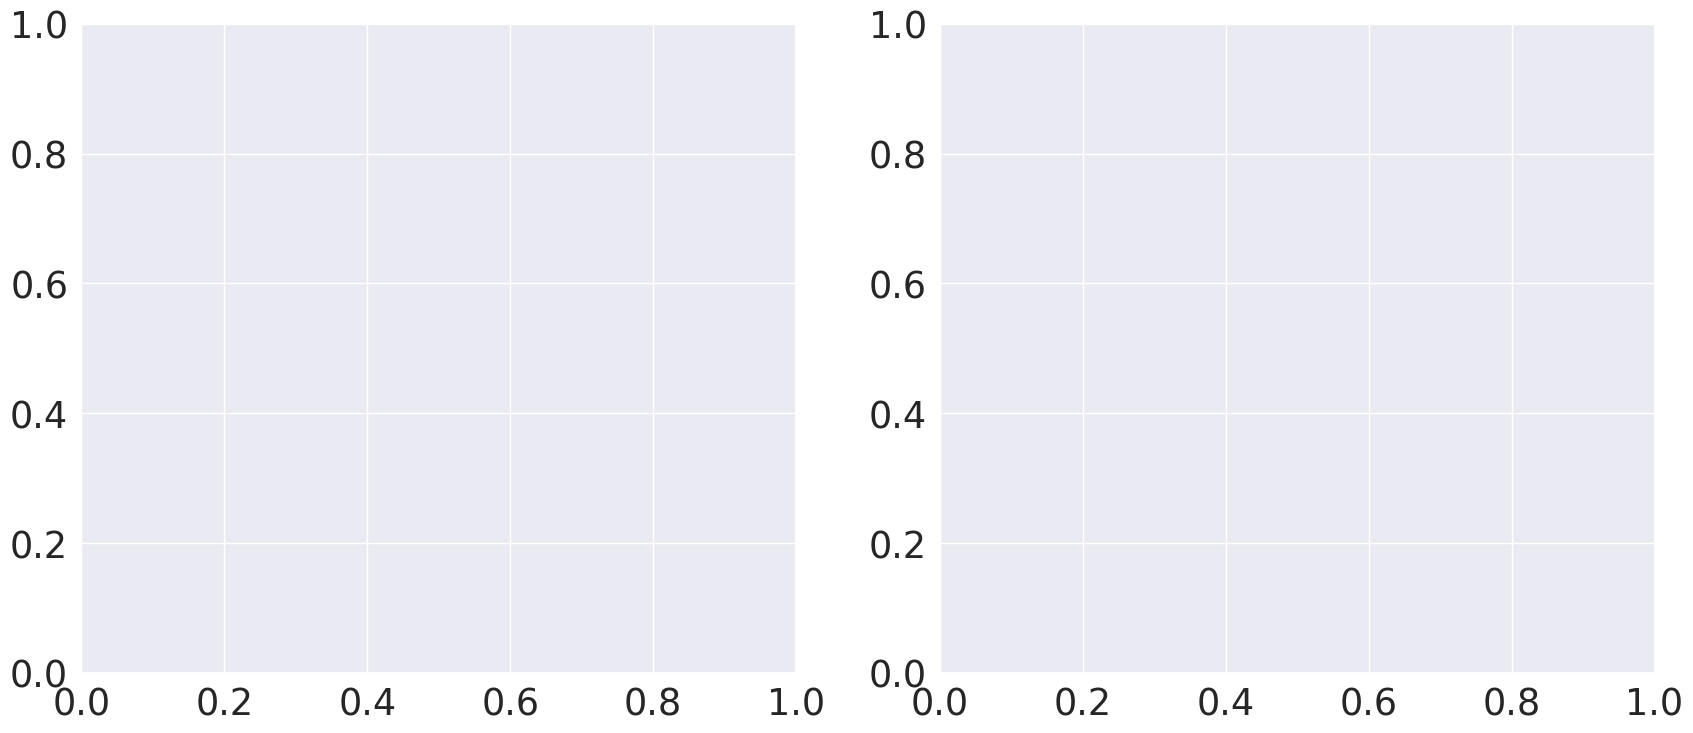

In [40]:
fig, axs = plt.subplots(figsize=(17.6,8), ncols=2)
fig.tight_layout()
aggregated = trading_aggregation(df.copy())
aggregated =aggregated.round(2)

aggregated["win2_mean_sem"] = aggregated["win_2mean"].astype(str) + "±" + aggregated["win_2sem"].astype(str)
aggregated["resource_delta_2_mean_sem"] = aggregated["resource_delta_2mean"].astype(str) + "±" + aggregated["resource_delta_2sem"].astype(str)

#######

# WinRate Plot

######
local_aggregate_one = aggregated.pivot(index="model_2", columns="model_1", values="win2_mean_sem")

local_aggregate_one = local_aggregate_one.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate_one = local_aggregate_one.reindex(AGENTS_CLEAN_NAMES)
# mask = np.eye(local_aggregate.values.shape[0], dtype=bool)


# first_plot = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f", cmap=colormap, ax=axs[0])
# first_plot.set_ylabel('Player 2', fontdict=dict(weight='bold', size=30))

# first_plot.set_xlabel('Player 1', fontdict=dict(weight='bold', size=30))
# first_plot.set_title('Win Rate')
# first_plot.set_xticklabels(labels=AGENTS_CLEAN_NAMES, rotation=30)

#######

# Payoff Plot

######

local_aggregate_two = aggregated.pivot(index="model_2", columns="model_1", values="resource_delta_2_mean_sem")

local_aggregate_two = local_aggregate_two.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate_two = local_aggregate_two.reindex(AGENTS_CLEAN_NAMES)
# mask = np.eye(local_aggregate.values.shape[0], dtype=bool)


# second_plot = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f", cmap=colormap, ax=axs[1])
# second_plot.set_ylabel('')
# second_plot.set_xlabel('Player 1', fontdict=dict(weight='bold', size=30))
# second_plot.set_title('Payoff')
# second_plot.set_xticklabels(labels=AGENTS_CLEAN_NAMES, rotation=30)
# second_plot.set_yticklabels(labels=[])

# fig.tight_layout()

# plt.savefig('figures/section_one_resource_exchange.pdf', bbox_inches='tight')
# plt.show()

## Ultimatum

In [44]:
log_dir = "../experiments/section_one/.logs/ultimatum_multi_section_one/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
df = compute_game_summary(game_states)

# we add 100 to restore the portion of money to P1
df["resource_delta_1"] = df["resource_delta_1"] + 100

# we set the delta of p1 to 0 of 100 ending games because it means they did not split the money
df.loc[df['resource_delta_1'] == 100, 'resource_delta_1'] = 0


# for some reasons this is not int, i have checked the data but does not seem corrupted?
# df[df["resource_delta_2"].apply(lambda x: isinstance(x, int))] returns all elements
df["resource_delta_1"] = df["resource_delta_1"].astype(int)


THERE ARE 720 log files
720 Loaded Successfully


In [49]:
def from_pandas_to_aggregation(new_df):
    df_copy = new_df.copy()
    

    
    df_copy['models'] = df_copy['model_1'] + '@' + df_copy['model_2']
    
    df_copy['win_1'] = df_copy['resource_delta_1'] > df_copy['resource_delta_2']
    df_copy['win_2'] = df_copy['resource_delta_1'] < df_copy['resource_delta_2']
    df_copy['draw'] = df_copy['resource_delta_1'] == df_copy['resource_delta_2']
    
    df_copy = df_copy.groupby(['game_name', 
                               'models'])[['win_1', 'win_2', 
                                           'resource_delta_1',
                                           'resource_delta_2']].agg(['mean', 'sem']).reset_index()
    
    df_copy[['model_1', 'model_2']] = df_copy['models'].str.split('@', n=1, expand=True)
    df_copy['win_1'] = df_copy['win_1'] / (df_copy['win_1'] + df_copy['win_2'])
    df_copy['win_2'] = df_copy['win_2'] / (df_copy['win_1'] + df_copy['win_2'])
    
    df_copy.columns = list(map(''.join, df_copy.columns.values))
    return df_copy





In [54]:
local_aggregate_two

model_2,GPT-4,Claude-2.1,Claude-2,GPT-3.5
model_1,,,,
GPT-4,NaN,60.33±1.58,60.42±1.36,49.67±3.3
Claude-2.1,61.22±1.47,NaN,67.83±2.51,61.27±4.01
Claude-2,58.08±1.26,70.58±2.71,NaN,49.73±4.64
GPT-3.5,54.5±3.32,60.0±3.63,59.25±2.39,NaN


### Win Rate

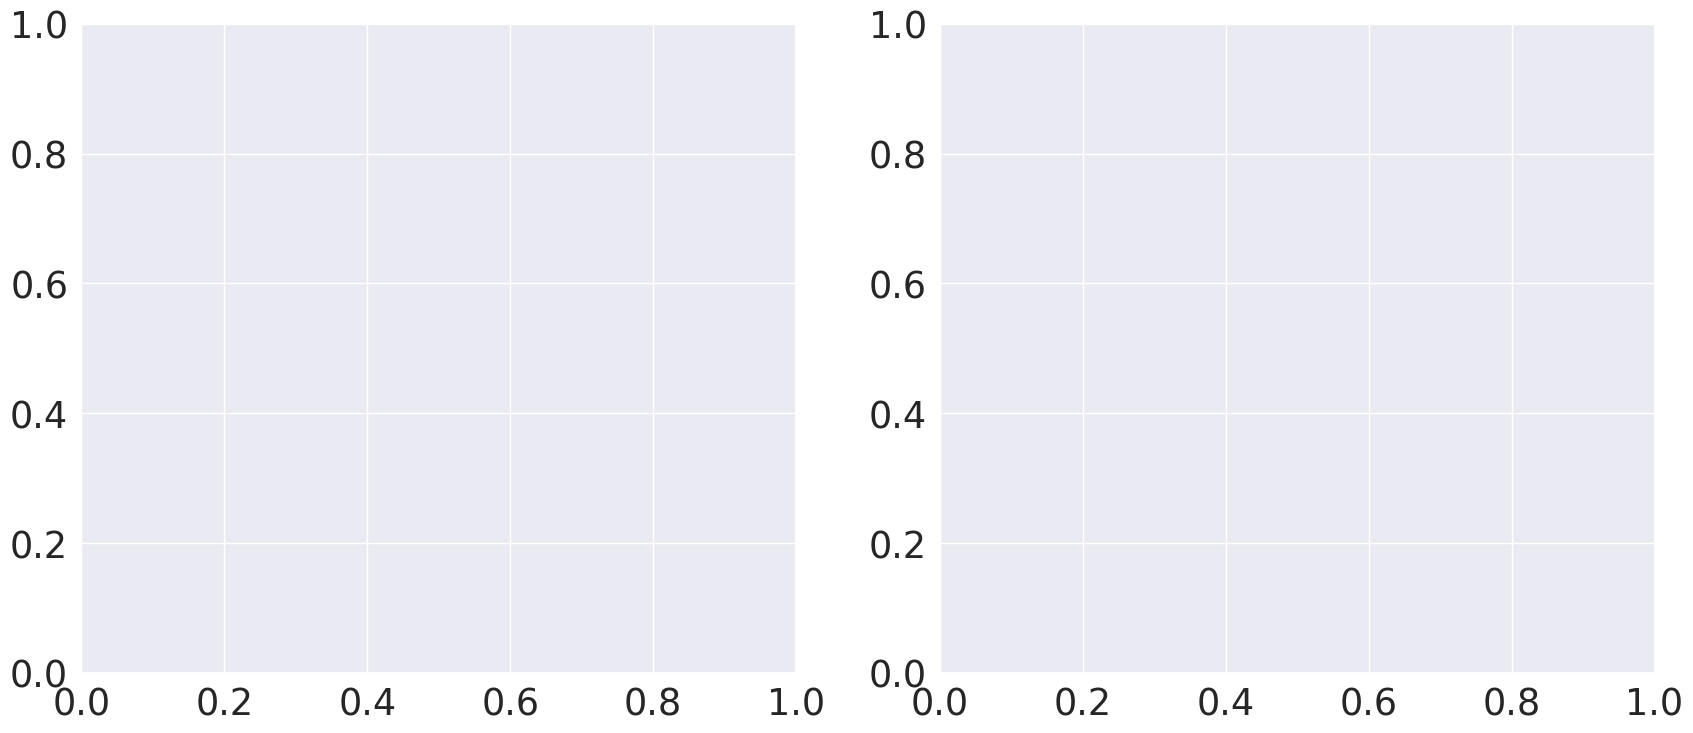

In [52]:
fig, axs = plt.subplots(figsize=(17.6,8), ncols=2)
fig.tight_layout()
aggregated = from_pandas_to_aggregation(df.copy())
aggregated =aggregated.round(2)

aggregated["win1_mean_sem"] = aggregated["win_1mean"].astype(str) + "±" + aggregated["win_1sem"].astype(str)
aggregated["resource_delta_1_mean_sem"] = aggregated["resource_delta_1mean"].astype(str) + "±" + aggregated["resource_delta_1sem"].astype(str)


# winrate plot
local_aggregate_one = aggregated.pivot(index="model_1", columns="model_2", values="win1_mean_sem")

local_aggregate_one = local_aggregate_one.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate_one = local_aggregate_one.reindex(AGENTS_CLEAN_NAMES)
mask = np.eye(local_aggregate.values.shape[0], dtype=bool)


# first_plot = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f", cmap=colormap, ax=axs[0])
# first_plot.set_title('Win Rate')
# first_plot.set_ylabel('Player 1', fontdict=dict(weight='bold', size=30))
# first_plot.set_xlabel('Player 2', fontdict=dict(weight='bold', size=30))
# first_plot.set_xticklabels(labels=AGENTS_CLEAN_NAMES, rotation=30)

# Payoff plot
local_aggregate_two = aggregated.pivot(index="model_1", columns="model_2", values="resource_delta_1_mean_sem")

local_aggregate_two = local_aggregate_two.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate_two = local_aggregate_two.reindex(AGENTS_CLEAN_NAMES)
mask = np.eye(local_aggregate.values.shape[0], dtype=bool)

# second_plot = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".1f", cmap=colormap, ax=axs[1])
# #second_plot.set(ylabel=None)
# #second_plot.set(xlabel="Payoff")
# second_plot.set_ylabel('')
# second_plot.set_xlabel('Player 2', fontdict=dict(weight='bold', size=30))
# second_plot.set_title('Payoff')
# second_plot.set_xticklabels(labels=AGENTS_CLEAN_NAMES, rotation=30)
# second_plot.set_yticklabels(labels=[])

# fig.tight_layout()
# plt.savefig('figures/section_one_ultimatum.pdf', bbox_inches='tight')
# plt.show()

# Seller and Buyer

In [16]:
log_dir = "../experiments/section_one/.logs/buysell_section_one/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
temp_df = compute_game_summary(game_states)


df = replace_names(temp_df.copy())

df["vals1"] = df["vals1"].apply(lambda x : x.valuation_dict["X"])
df["vals2"] = df["vals2"].apply(lambda x : x.valuation_dict["X"])

THERE ARE 914 log files
914 Loaded Successfully


### BuySell Payoffs

For each model, we want to extract the payoff against the other players

In [20]:
gb = df.groupby('vals1')    
seller_at_40, seller_at_60 = [gb.get_group(x).copy() for x in gb.groups]

In [21]:
assert seller_at_40.iloc[0]["vals1"] == 40
(seller_at_40["outcome_2"]==0).sum()

8

In [7]:
import warnings

# SEM bars gives errors
warnings.filterwarnings('ignore')


In [8]:
import matplotlib.patches as mpatches

sns.set_context("poster")
sns.set_palette("colorblind")


#### Seller at 60

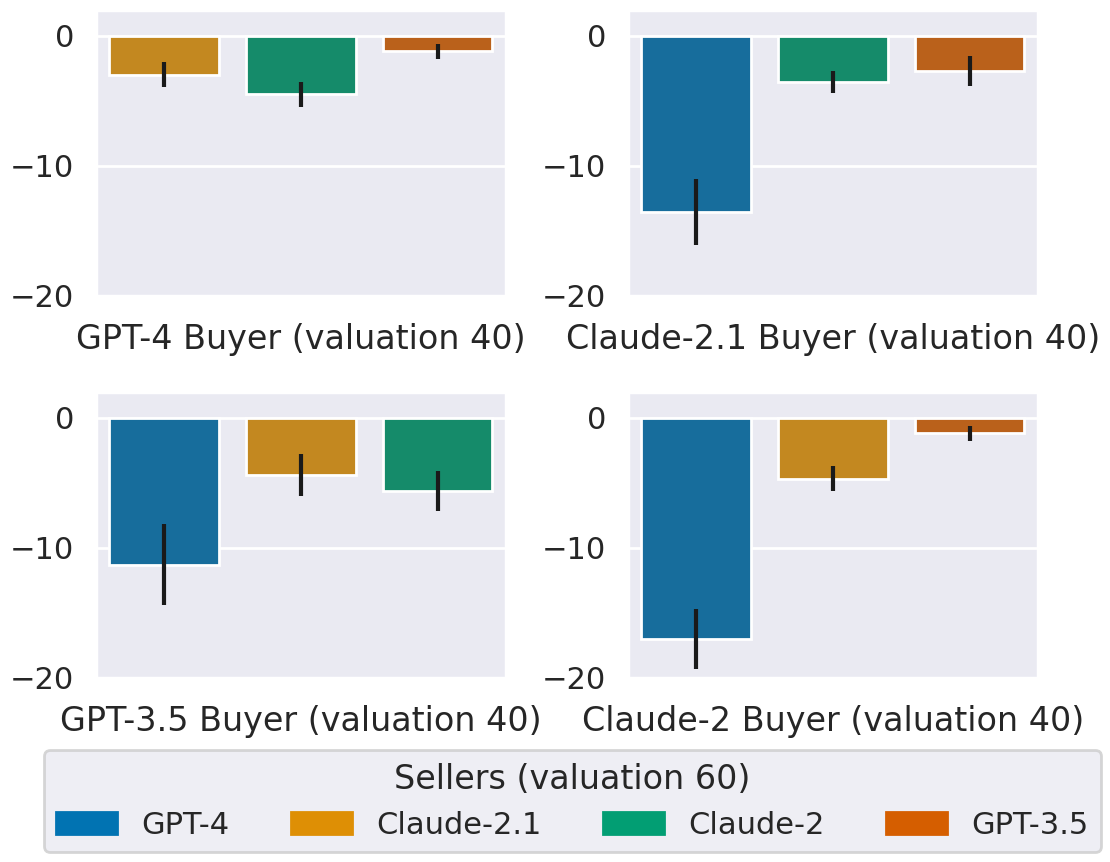

In [51]:
fig, axs = plt.subplots(2,2, figsize=(11,8))
fig.tight_layout()

unique = ['GPT-4', 'Claude-2.1', 'Claude-2', 'GPT-3.5']

palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))

for local_agent_plot, locs in zip(AGENTS_CLEAN_NAMES, [axs[0,0], axs[0,1], axs[1,1], axs[1,0]]):
    
    aggregated = seller_at_60.groupby(["model_1", "model_2"])[['outcome_1', 'outcome_2',
           'resource_delta_1', 'resource_delta_2']].agg(['mean', "sem"]).reset_index().copy()
    aggregated.columns = list(map(''.join, aggregated.columns.values))

    aggregated = aggregated[aggregated["model_2"].isin([local_agent_plot])]

    # names to plot things
    local_copy_of_agents = AGENTS_CLEAN_NAMES[:]
    local_copy_of_agents.remove(local_agent_plot)
    aggregated.index = aggregated["model_1"]
    aggregated = aggregated.reindex(local_copy_of_agents)
    
    figu = sns.barplot(aggregated, x="model_1", y="outcome_2mean", order=local_copy_of_agents,
                       hue="model_1", dodge=False, ax=locs, palette=palette,  yerr=aggregated["outcome_2sem"])
    figu.legend_.remove()
    #figu.legend(title=f'Sellers (valuation 40)', loc='upper right')
    
    figu.set(ylabel=None)
    figu.set_ylim(-20, 2)
    figu.set(xlabel=f"{local_agent_plot} Buyer (valuation 40)")
    figu.set_xticklabels(labels=[])

#handles, labels = axs[-1][-1].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center')
custom_lines = [
    mpatches.RegularPolygon((0, 0), 5, radius=0.1, color=p) for p in list(palette.values())]
      
from matplotlib.lines import Line2D
fig.tight_layout()


axs[1,1].legend(custom_lines, palette.keys(), ncol=4, loc='upper center', bbox_to_anchor=(-0.135, -0.20), title=f'Sellers (valuation 60)')

fig.get_figure().savefig('figures/section_one_seller_at_60.pdf', bbox_inches='tight')
plt.show()

#### Seller at 40

In [24]:
seller_at_40[seller_at_40["model_2"] == "GPT-4"]["outcome_2"].mean()

18.633333333333333

,model_1,model_2,outcome_1mean,outcome_1sem,outcome_2mean,outcome_2sem,resource_delta_1mean,resource_delta_1sem,resource_delta_2mean,resource_delta_2sem
1,Claude-2,GPT-3.5,5.9,0.509625,13.766667,0.551509,5.9,0.509625,13.766667,0.551509
4,Claude-2.1,GPT-3.5,6.45,0.422813,13.55,0.422813,6.45,0.422813,13.55,0.422813
11,GPT-4,GPT-3.5,6.75,0.479892,12.583333,0.544252,6.75,0.479892,12.583333,0.544252


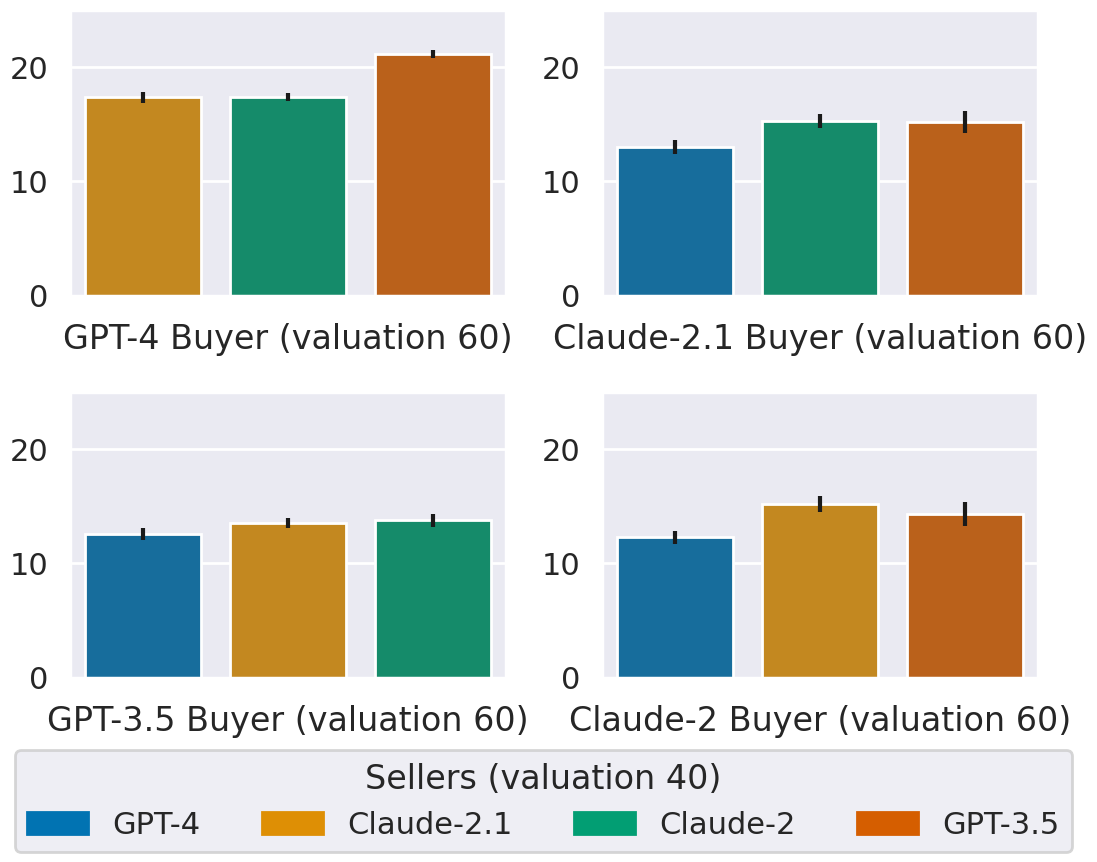

In [48]:
fig, axs = plt.subplots(2,2, figsize=(11,8))
fig.tight_layout()

unique = ['GPT-4', 'Claude-2.1', 'Claude-2', 'GPT-3.5']

palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))

for local_agent_plot, locs in zip(AGENTS_CLEAN_NAMES, [axs[0,0], axs[0,1], axs[1,1], axs[1,0]]):
    
    aggregated = seller_at_40.groupby(["model_1", "model_2"])[['outcome_1', 'outcome_2',
           'resource_delta_1', 'resource_delta_2']].agg(['mean', "sem"]).reset_index().copy()
    aggregated.columns = list(map(''.join, aggregated.columns.values))

    aggregated = aggregated[aggregated["model_2"].isin([local_agent_plot])]

    # names to plot things
    local_copy_of_agents = AGENTS_CLEAN_NAMES[:]
    local_copy_of_agents.remove(local_agent_plot)
    aggregated.index = aggregated["model_1"]
    aggregated = aggregated.reindex(local_copy_of_agents)
    
    figu = sns.barplot(aggregated, x="model_1", y="outcome_2mean", order=local_copy_of_agents,
                       hue="model_1", dodge=False, ax=locs, palette=palette, 
                       yerr=aggregated["outcome_2sem"], capsize=.2)
    figu.legend_.remove()
    #figu.legend(title=f'Sellers (valuation 40)', loc='upper right')
    
    figu.set(ylabel=None)
    figu.set_ylim(0, 25)
    figu.set(xlabel=f"{local_agent_plot} Buyer (valuation 60)")
    figu.set_xticklabels(labels=[])

#handles, labels = axs[-1][-1].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center')
custom_lines = [
    mpatches.RegularPolygon((0, 0), 5, radius=0.1, color=p) for p in list(palette.values())]
      
from matplotlib.lines import Line2D
fig.tight_layout()


axs[1,1].legend(custom_lines, palette.keys(), ncol=4, loc='upper center', bbox_to_anchor=(-0.135, -0.20), title=f'Sellers (valuation 40)')



fig.get_figure().savefig('figures/section_one_seller_at_40.pdf', bbox_inches='tight')
plt.show()